<a href="https://colab.research.google.com/github/andersonsam/climate_flow_seasonality/blob/main/climate_flow_seasonality_gif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data; change this to wherever you have the data saved!

In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4

     |████████████████████████████████| 1.0MB 13.7MB/s 
     |████████████████████████████████| 15.3MB 61.2MB/s 
     |████████████████████████████████| 6.5MB 49.3MB/s 
     |████████████████████████████████| 4.7MB 14.7MB/s 
     |████████████████████████████████| 317kB 58.2MB/s 
     |████████████████████████████████| 614kB 13.8MB/s 


In [3]:
#import required libraries

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

import pickle
import os
from datetime import datetime, date, timedelta
from netCDF4 import Dataset
from google.colab import drive
import imageio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#define functions

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')



# Load data

In [8]:
#load daily maximum temperature data
pickle_in = open(dir_data + '/' + 'maxTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]
extentERA = [np.min(eraLon),np.max(eraLon),np.min(eraLat),np.max(eraLat)]
Tmax = np.asarray(tempDict['Tmax'])

#load daily minimum temperature data
pickle_in = open(dir_data + '/' + 'minTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
Tmin = np.asarray(tempDict['Tmin'])

#calculate mean temperature
Tmean = np.mean([Tmax,Tmin], axis = 0)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)
P = np.asarray(precDict['P'])

#data prep
Nlat = np.shape(Tmax)[1] #number of grid cells: latitude
Nlon = np.shape(Tmax)[2] #number of grid cells: longitude
Npx = Nlat*Nlon #number of pixels

Tmax_px = Tmax.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmin_px = Tmin.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmean_px = Tmean.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_px = P.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_px_new = np.zeros(np.shape(Tmin_px)) #last day temp data missing; fill with 0s
P_px_new[:-1,:] = np.copy(P_px)
P_px = P_px_new

#reformat: rather than long list of observations, calculate each year
delta = timedelta(days = 364)
year_start = 1979
year_fin = 2018

#initialize
Tmax_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1)))) #days in year  x  pixel  x  year
Tmin_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
Tmean_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
P_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))

# kk = 0
#for each year
for nn, year in enumerate(range(year_start, year_fin+1)):

  start_date = datetime(year, 1, 1)
  fin_date = start_date + delta

  start_ind = eraDate.index(start_date)
  fin_ind = eraDate.index(fin_date)

  Tmax_seasonal_yearly[:,:,nn] = Tmax_px[start_ind:fin_ind+1,:]
  Tmin_seasonal_yearly[:,:,nn] = Tmin_px[start_ind:fin_ind+1,:]
  Tmean_seasonal_yearly[:,:,nn] = Tmean_px[start_ind:fin_ind+1,:]
  P_seasonal_yearly[:,:,nn] = P_px[start_ind:fin_ind+1,:]

#calculate seasonal averages
Tmax_seasonal = np.mean(Tmax_seasonal_yearly, axis = -1)
Tmin_seasonal = np.mean(Tmin_seasonal_yearly, axis = -1)
Tmean_seasonal = np.mean(Tmean_seasonal_yearly, axis = -1).T
P_seasonal = np.mean(P_seasonal_yearly, axis = -1).T

In [37]:
#load flow data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

F_seasonal = flowDict['all_flowseason_NF']
F_seasonal /= np.expand_dims(np.max(F_seasonal, axis = 1), axis = -1)
stationLon = flowDict['stationLon']
stationLat = flowDict['stationLat']
Nstations = len(stationLat)

#smooth
Nstations = len(stationLat)
for station in range(Nstations):
  F_seasonal[station,:] = pd.Series(F_seasonal[station,:]).rolling(window = 30, min_periods = 1).mean().values

# Make and save gif

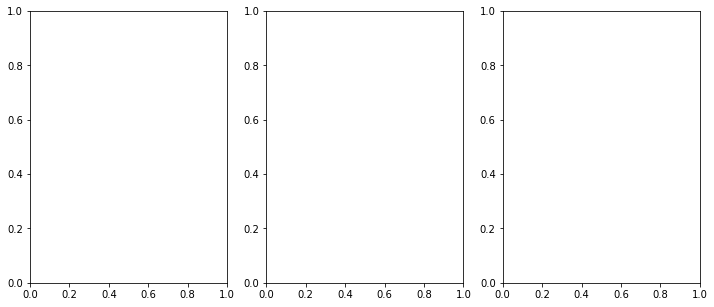

In [70]:
#help from: https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30

nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 5*nrows))

days = [int(day) for day in np.arange(0,365,1)]
date_strings = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for kk in range(365):
  ds = months[int(eraMonths[kk])-1] + ' ' + str(eraDays[kk])
  date_strings.append(ds)

filenames = []
for day in days:

  #mean temp
  var = Tmean_seasonal
  vmin = np.min(var)
  vmax = np.max(var)
  axes[0].imshow(var[:,day].reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax, cmap = 'RdBu_r')
  plot_prov_ax(prov = ['AB','BC'], ax = axes[0])
  axes[0].set_ylabel('Latitude', fontsize = 12)
  axes[0].set_title('Mean Temperature', fontsize = 12)

  #precip
  var = P_seasonal
  vmin = np.min(var)
  vmax = np.max(var)/2
  axes[1].imshow(var[:,day].reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax, cmap = 'RdBu')
  plot_prov_ax(prov = ['AB','BC'], ax = axes[1])
  axes[1].set_xlabel('Longitude', fontsize = 12)
  axes[1].set_title(date_strings[day] + '\nPrecipitation', fontsize = 12)

  #flow
  var = F_seasonal
  vmin = np.min(var)
  vmax = np.max(var)
  axes[2].scatter(stationLon, stationLat, c = F_seasonal[:,day], cmap = 'Blues', s = 75, edgecolor = 'k')
  plot_prov_ax(prov = ['AB','BC'], ax = axes[2])
  axes[2].set_title('Normalized Streamflow', fontsize = 12)

  filename = 'Day_' + str(day) + '.png'
  filenames.append(filename)

  plt.savefig(filename, bbox_inches = 'tight')

  axes[0].clear()
  axes[1].clear()
  axes[2].clear()

In [71]:
#save as a gif
with imageio.get_writer('seasonality.gif', mode = 'I') as writer:
  for kk, filename in enumerate(filenames):
    if np.mod(kk,10)==0:
      image = imageio.imread(filename)
      writer.append_data(image)

# # If you want to remove files
# for filename in set(filenames):
#   os.remove(filename)